In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from patsy import dmatrices, dmatrix
from math import inf

In [4]:
import warnings
warnings.filterwarnings("ignore")

Importing data

In [5]:
data = pd.read_csv('new_data.csv').iloc[:, 1:]

In [6]:
data

,Full_Date,Date,Day,Interest_Rate
0,1999-01-01,1999,1 Jan.,3.00
1,1999-02-01,1999,1 Jan.,3.00
2,1999-03-01,1999,1 Jan.,3.00
3,1999-04-01,1999,9 Apr.,2.50
4,1999-05-01,1999,9 Apr.,2.50
...,...,...,...,...
292,2023-05-01,2023,10 May,3.75
293,2023-06-01,2023,21 Jun.,4.00
294,2023-07-01,2023,21 Jun.,4.00
295,2023-08-01,2023,2 Aug.,4.25


In [7]:
data['Full_Date'] = pd.to_datetime(data['Full_Date'])

In [8]:
data.index = pd.to_datetime(data['Full_Date'])
data.drop(columns = 'Full_Date', inplace = True)

Train-Test Split:

In [9]:
split = round(len(data)*0.80)
full_train = data.iloc[:split, ].copy()
test = data.iloc[split:, ].copy()

## Inspection and ARIMA modeling of the interest rate time-series

In this first section, the interest rate series is modeled through ARIMA without making using of covariates. To do so, we are going to select the parameters p, d, and q through the inspection of the series and its autocorrelation and partial autocorrelation functions.

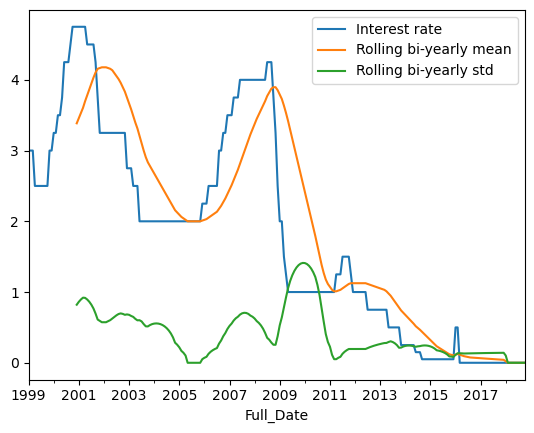

In [11]:
full_train['Interest_Rate'].plot(label = 'Interest rate')
full_train['Interest_Rate'].rolling(24).mean().plot(label = 'Rolling bi-yearly mean')
full_train['Interest_Rate'].rolling(24).std().plot(label = 'Rolling bi-yearly std')
plt.legend()
plt.show()

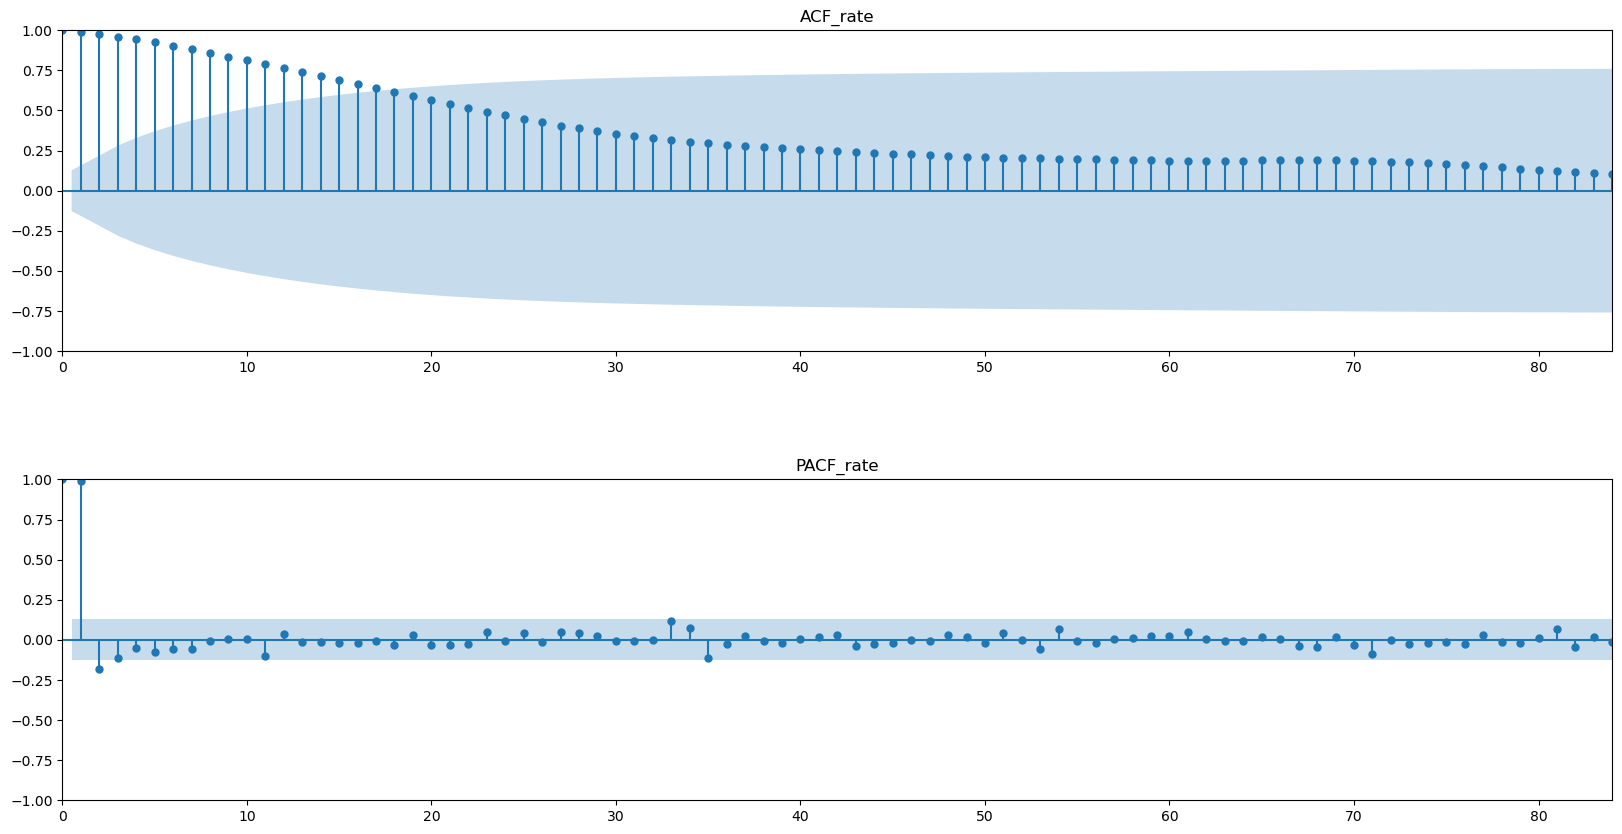

In [40]:
lag = 12*7
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(full_train['Interest_Rate'], ax = axes[0], lags = lag,
                title = 'ACF_rate')

plot_pacf(full_train['Interest_Rate'], ax = axes[1], lags = lag,
                title = 'PACF_rate')
plt.show()

Observing the plotted interest rate and its rolling mean, which fluctuates and is mostly decreasing through time, and by the autocorrelation coefficients being quite persistent, we see that the interest rate series is trending and so clearly not stationary. This could be either due to a unit root with drift or to a deterministic time trend.

To check for the possibility of the process being a unit root process, we perform the Augmented Dickey-Fuller test. We set a threshold of 0.05:

In [51]:
adfuller(full_train['Interest_Rate'], regression = 'ct')

(-3.3066019730434997,
 0.06517438136265616,
 3,
 234,
 {'1%': -3.9979881078231756,
  '5%': -3.4294209574472734,
  '10%': -3.138173000968399},
 -256.5585828085468)

The p-value is quite small, but since it is above the threshold we set, then we cannot reject the null hypotheses, and we take evidence from the ADF test as not disproving the presence of a unit root.

In order to make the series stationary, we try taking the first order differences:

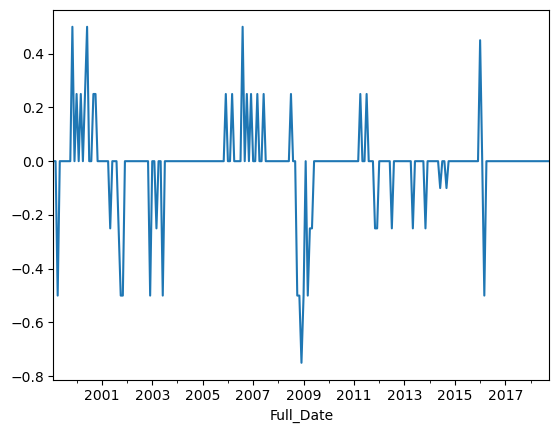

In [52]:
rate_diff_full_train = full_train['Interest_Rate'].diff().dropna()
rate_diff_full_train.plot()
plt.show()

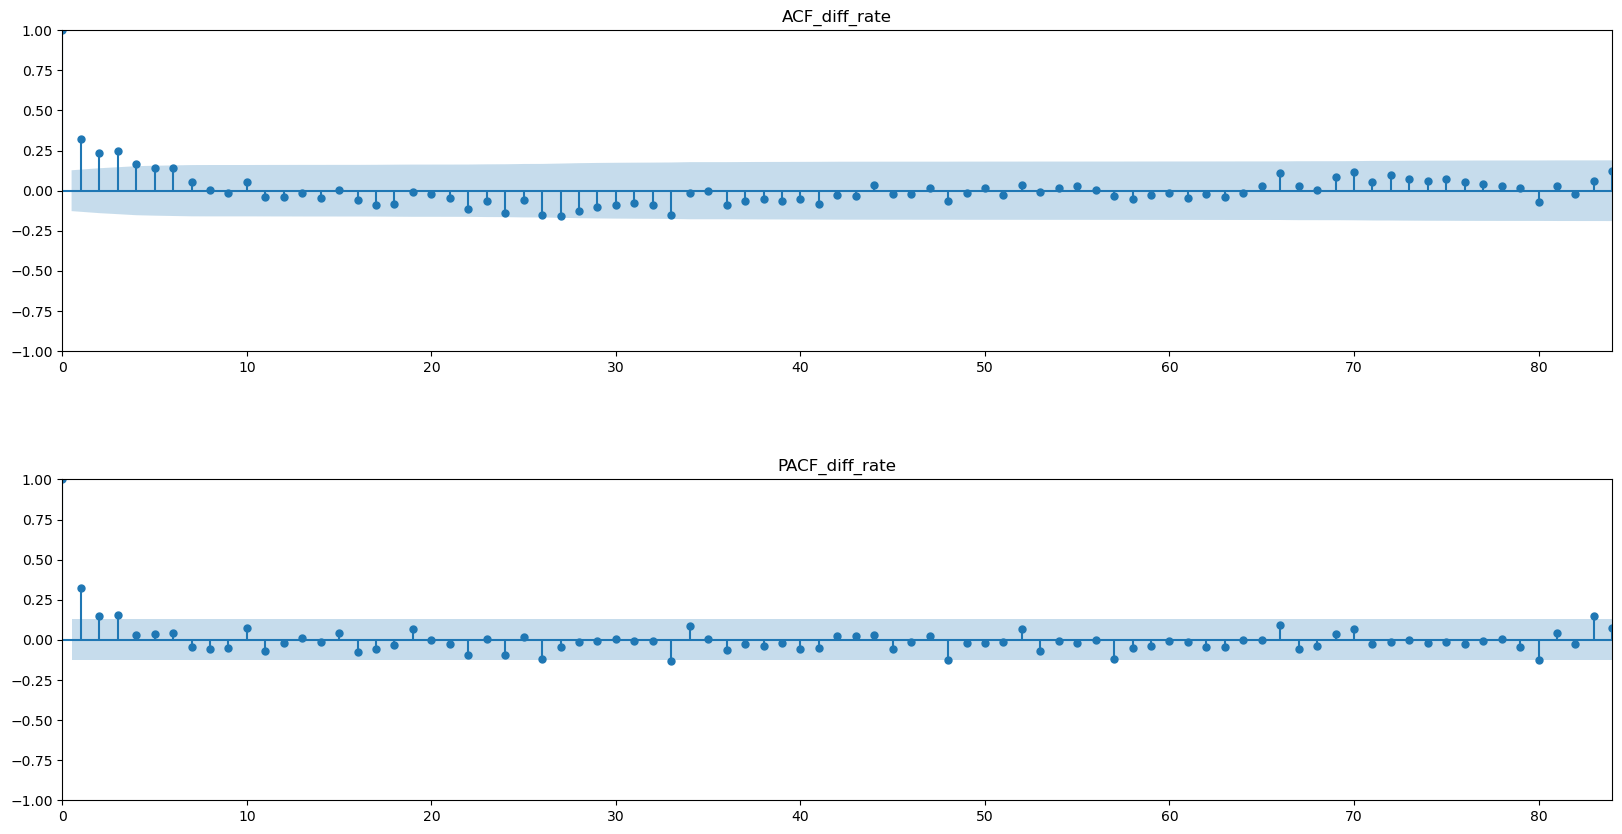

In [48]:
lag = 12*7
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(rate_diff_full_train, ax = axes[0], lags = lag,
                title = 'ACF_diff_rate')

plot_pacf(rate_diff_full_train, ax = axes[1], lags = lag,
                title = 'PACF_diff_rate')
plt.show()

The differenced series is not trending and not persistent. We test the stationarity of the series using again the ADF test.

In [53]:
adfuller(rate_diff_full_train, regression = 'c')

(-5.970370833486023,
 1.9427099556058582e-07,
 2,
 234,
 {'1%': -3.4586084859607156,
  '5%': -2.873972159235721,
  '10%': -2.57339565928848},
 -253.63430454655912)

The p-value is extremely small, by which we can exclude the presence of another unit root and consider the series stationary.

Hence, we probably do not need to difference again: we set the ARIMA parameter d equal to 1. <br>
Observing the plots related to the differenced series, we see both the ACF and the PACF having significant spikes till lag-3, after which the ACF geometrically decays, and the PACF is truncated. Then, we set the order of the AR component to 3 and the order of the MA component to 0. Also, there is no sign of seasonality in the series, so we do not extend the model to take a seasonal component into account. <br>

However, before fitting the model, we try again to difference the series, to see if we should really exclude this possibility:

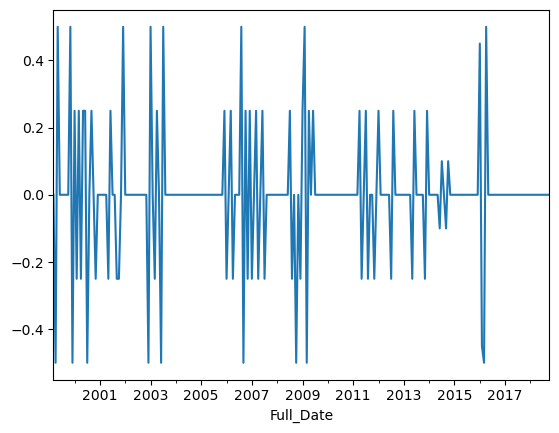

In [54]:
rate_diff2_full_train = rate_diff_full_train.diff().dropna()
rate_diff2_full_train.plot()
plt.show()

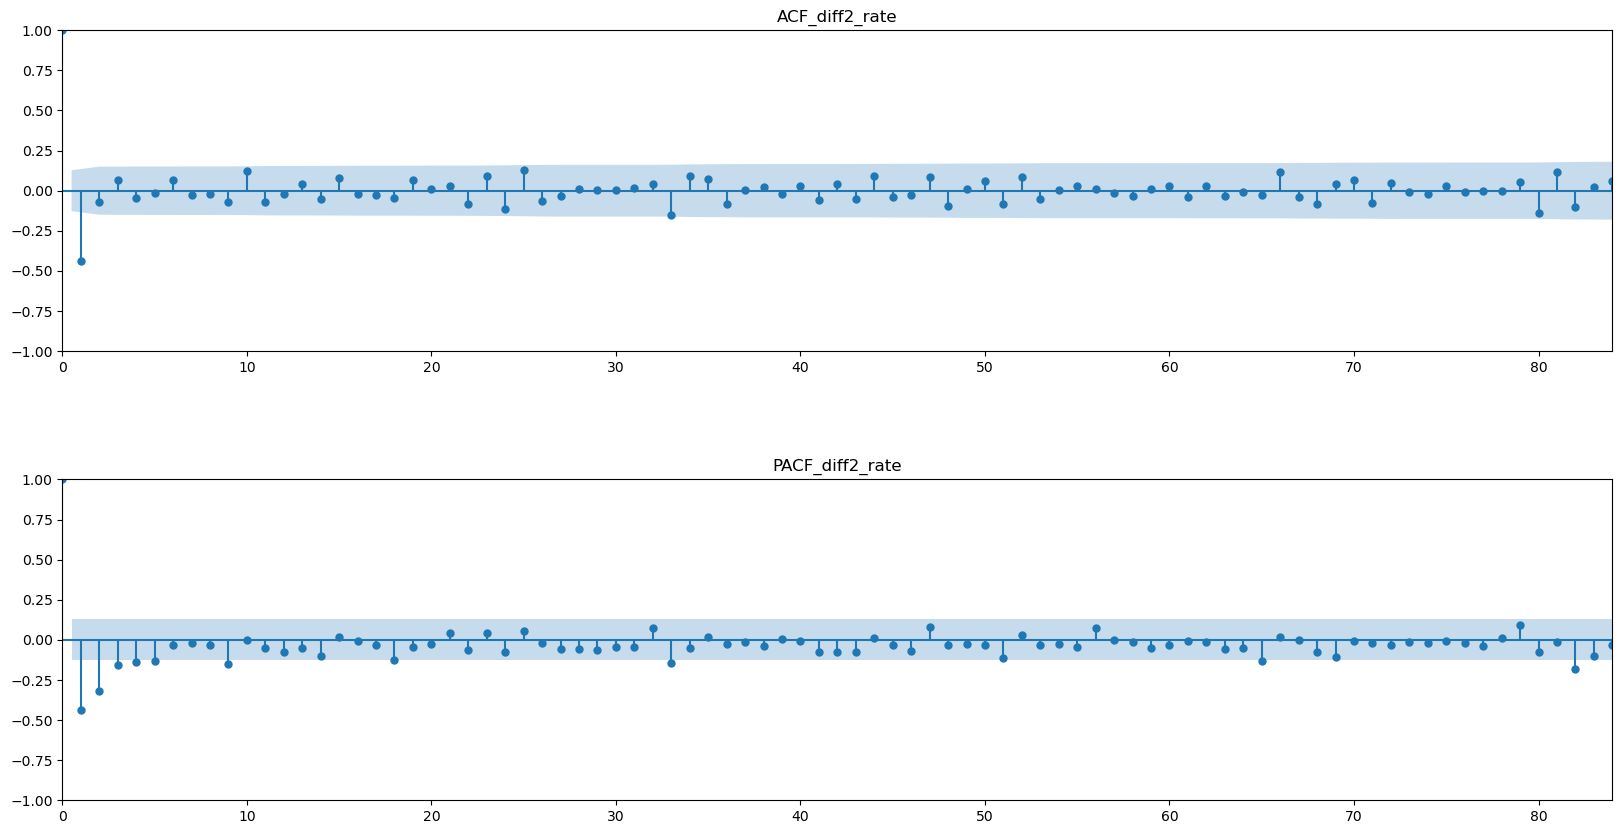

In [55]:
lag = 12*7
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(rate_diff2_full_train, ax = axes[0], lags = lag,
                title = 'ACF_diff2_rate')

plot_pacf(rate_diff2_full_train, ax = axes[1], lags = lag,
                title = 'PACF_diff2_rate')
plt.show()

We see a negative lag-1 autocorrelation, indicating, as expected, that the series is probably over-differenced and so we should stick to d = 1.

Our model for the interest rate is then ARIMA(3, 1, 0). We fit it to the training data and evaluate it.

In [116]:
arima = ARIMA(endog = full_train['Interest_Rate'], order=(3, 1, 0), seasonal_order = (0, 0, 0, 0))
arima_res = arima.fit()
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Interest_Rate   No. Observations:                  238
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 127.924
Date:                Mon, 05 Feb 2024   AIC                           -247.848
Time:                        12:39:52   BIC                           -233.976
Sample:                    01-01-1999   HQIC                          -242.257
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2528      0.051      4.936      0.000       0.152       0.353
ar.L2          0.1047      0.048      2.175      0.030       0.010       0.199
ar.L3          0.1595      0.049      3.226      0.001       0.063       0.256
sigma2         0.0199      0.001     19.351      0.000       0.018       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               307.71
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Before evaluation, we want to see that the residuals of the ARIMA do not display any remaining time dependence. The Ljung-Box test does exactly that, and, since its p-value is 0.94, we cannot reject the null hypothesis of no time dependence. Thus the model residuals can be assumed to be a white noise, as desired. To the same aim, we can plot the ACF and PACF of the residuals of the model:

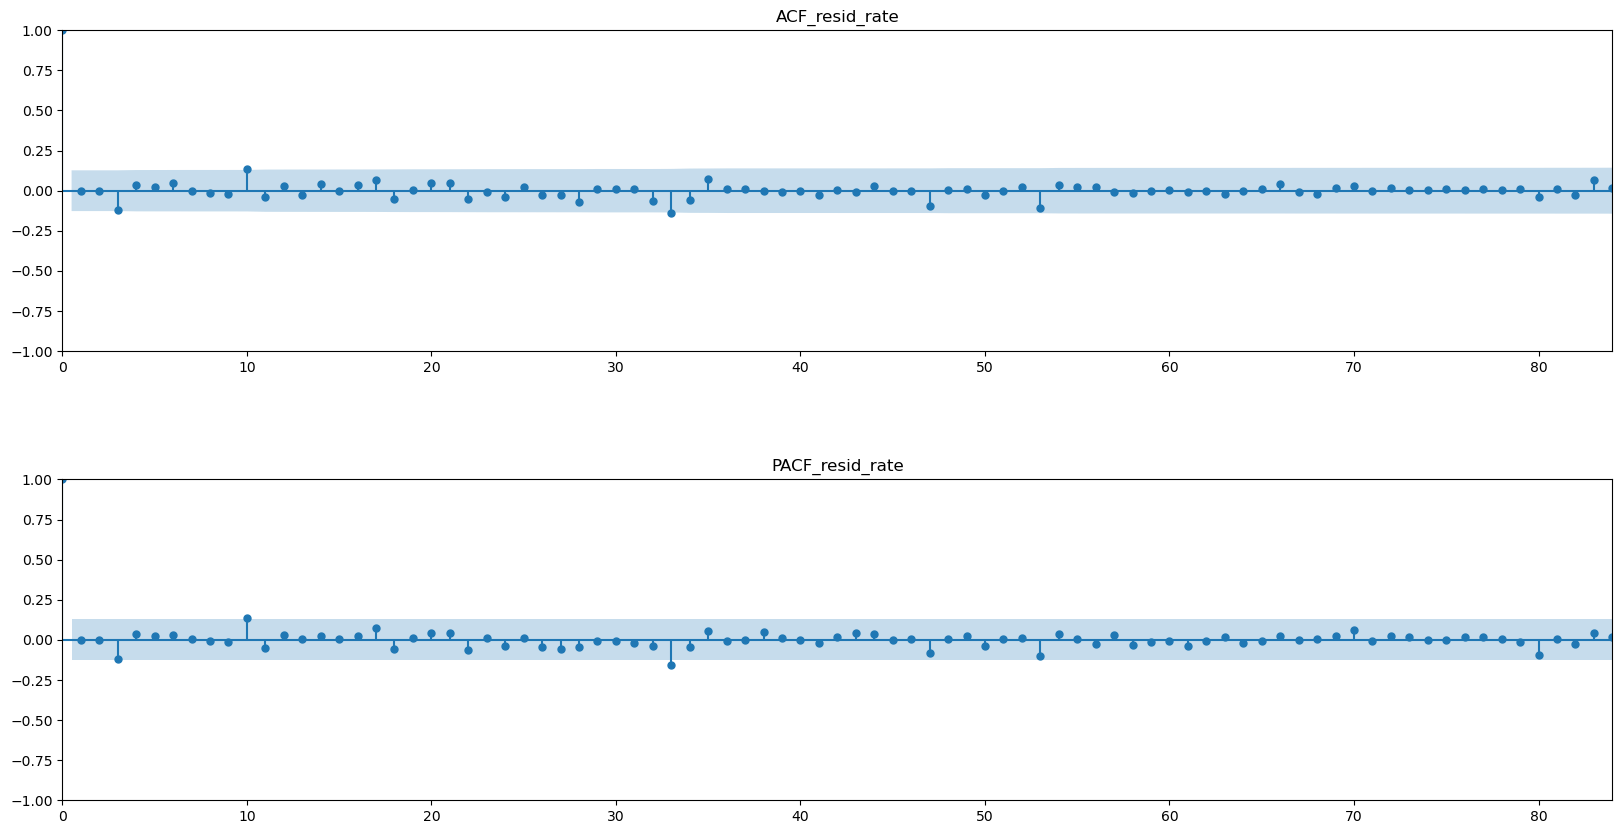

In [60]:
lag = 12*7
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(arima_res.resid, ax = axes[0], lags = lag,
                title = 'ACF_resid_rate')

plot_pacf(arima_res.resid, ax = axes[1], lags = lag,
                title = 'PACF_resid_rate')
plt.show()

We see indeed that the residuals appear to be white noise.

Now, we evaluate the model performance on the test set:

In [118]:
steps = len(test)
preds_arima = arima_res.get_forecast(steps = steps)
preds_arima_sf = preds_arima.summary_frame()

In [119]:
preds_arima_sf.head()

Interest_Rate,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-11-01,1.998446e-135,0.140968,-0.276292,0.276292
2018-12-01,2.308696e-135,0.225969,-0.442891,0.442891
2019-01-01,2.677139e-135,0.302018,-0.591943,0.591943
2019-02-01,3.119067e-135,0.381208,-0.747153,0.747153
2019-03-01,3.318857e-135,0.455283,-0.892338,0.892338


In [121]:
arima_pred = preds_arima_sf['mean']

In [122]:
#ARIMA MSE
((arima_pred - test['Interest_Rate'])**2).mean()

2.3389830508474576

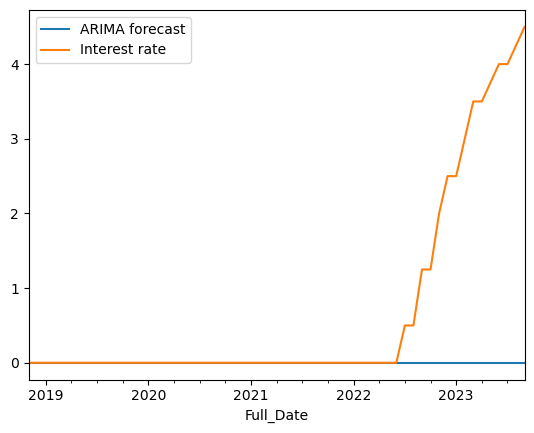

In [65]:
arima_pred.plot(label = 'ARIMA forecast')
test['Interest_Rate'].plot(label = 'Interest rate')
plt.legend()
plt.show()

Finally, we plot the predictions of the ARIMA together with the prediction intervals at level 0.7 and 0.95.

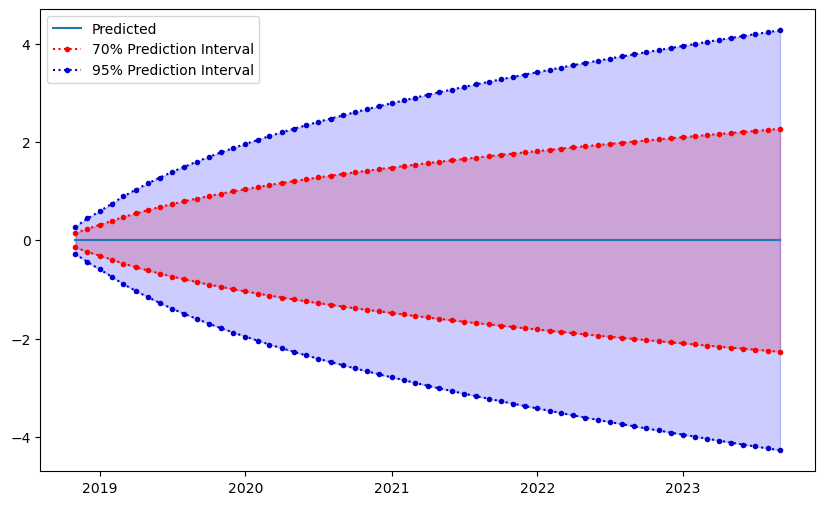

In [123]:
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(preds_arima_sf.loc[:, 'mean'], label = 'Predicted')

axes.plot(preds_arima_sf['mean'] - 1.04*preds_arima_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':')
axes.plot(preds_arima_sf['mean'] + 1.04*preds_arima_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':', label='70% Prediction Interval')

axes.fill_between(preds_arima_sf.index, preds_arima_sf['mean'] - 1.04*preds_arima_sf['mean_se'], 
                  preds_arima_sf['mean'] + 1.04*preds_arima_sf['mean_se'], 
                  color = 'r', alpha = 0.2)

axes.plot(preds_arima_sf.loc[:, 'mean_ci_lower'], 
                 color='#0000cc', marker='.', linestyle=':')
axes.plot(preds_arima_sf.loc[:, 'mean_ci_upper'], 
                 color='#0000cc', marker='.', linestyle=':', label='95% Prediction Interval')

axes.fill_between(preds_arima_sf.index, preds_arima_sf.loc[:, 'mean_ci_lower'], 
                  preds_arima_sf.loc[:, 'mean_ci_upper'], 
                  color = 'b', alpha = 0.2)

axes.legend()
plt.show()

We can also try to fit this model to the entire data set and plot forecasts from Oct 2023 to Dec 2024:

In [103]:
arima_full = ARIMA(endog = data['Interest_Rate'], order=(3, 1, 0), seasonal_order = (0, 0, 0, 0))
arima_full_res = arima_full.fit()

In [104]:
steps = 15
preds_arima_full = arima_full_res.get_forecast(steps = steps)
preds_arima_full_sf = preds_arima_full.summary_frame()

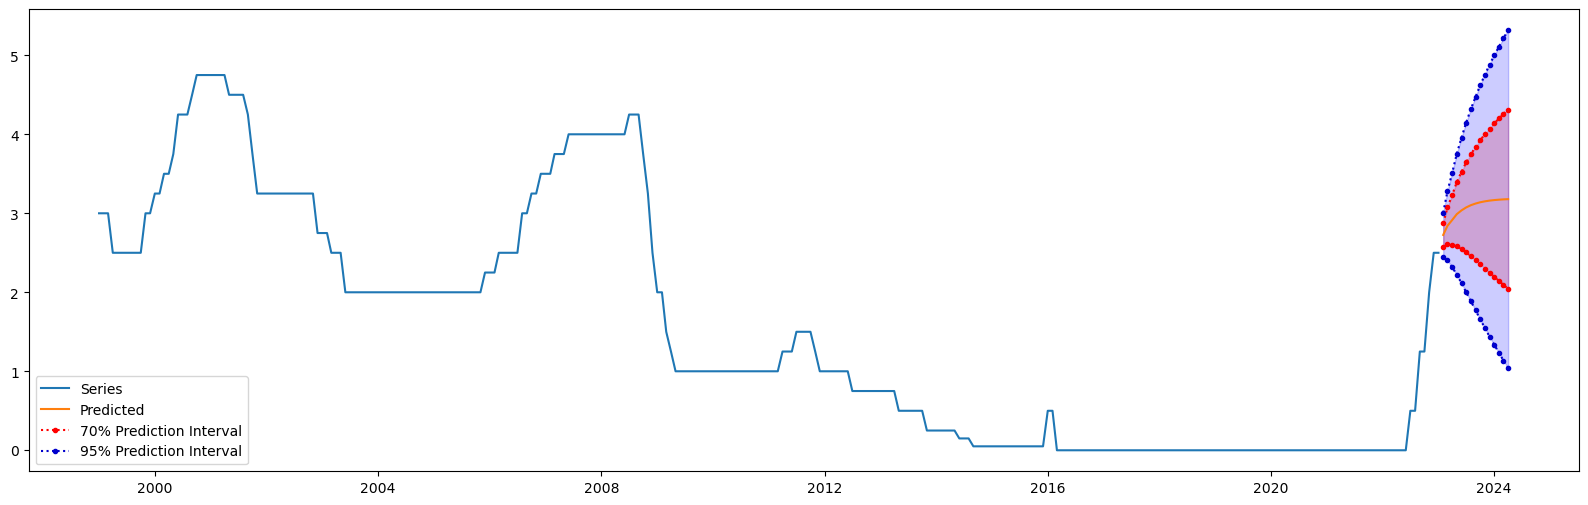

In [106]:
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(20)

axes.plot(data['Interest_Rate'], label = 'Series')

axes.plot(preds_arima_full_sf.loc[:, 'mean'], label = 'Predicted')

axes.plot(preds_arima_full_sf['mean'] - 1.04*preds_arima_full_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':')
axes.plot(preds_arima_full_sf['mean'] + 1.04*preds_arima_full_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':', label='70% Prediction Interval')

axes.fill_between(preds_arima_full_sf.index, preds_arima_full_sf['mean'] - 1.04*preds_arima_full_sf['mean_se'], 
                  preds_arima_full_sf['mean'] + 1.04*preds_arima_full_sf['mean_se'], 
                  color = 'r', alpha = 0.2)

axes.plot(preds_arima_full_sf.loc[:, 'mean_ci_lower'], 
                 color='#0000cc', marker='.', linestyle=':')
axes.plot(preds_arima_full_sf.loc[:, 'mean_ci_upper'], 
                 color='#0000cc', marker='.', linestyle=':', label='95% Prediction Interval')

axes.fill_between(preds_arima_full_sf.index, preds_arima_full_sf.loc[:, 'mean_ci_lower'], 
                  preds_arima_full_sf.loc[:, 'mean_ci_upper'], 
                  color = 'b', alpha = 0.2)

axes.legend()
plt.show()

## Linear regression on covariates

From now on, we will make use of a set of regressors for prediction. As a first step, we estimate a simple OLS regression. Then, we will model the residuals using (S)ARIMA as before.

In [124]:
data = pd.read_csv('data.csv').iloc[:, 1:] #we make use of this data to align to covariates

In [125]:
data.index = pd.to_datetime(data['Full_Date'])
data.drop(columns = 'Full_Date', inplace = True)

In [126]:
var_cols = ['Interest_Rate',
            'Inflation',
            'BCI',
            'LT',
            'ST']

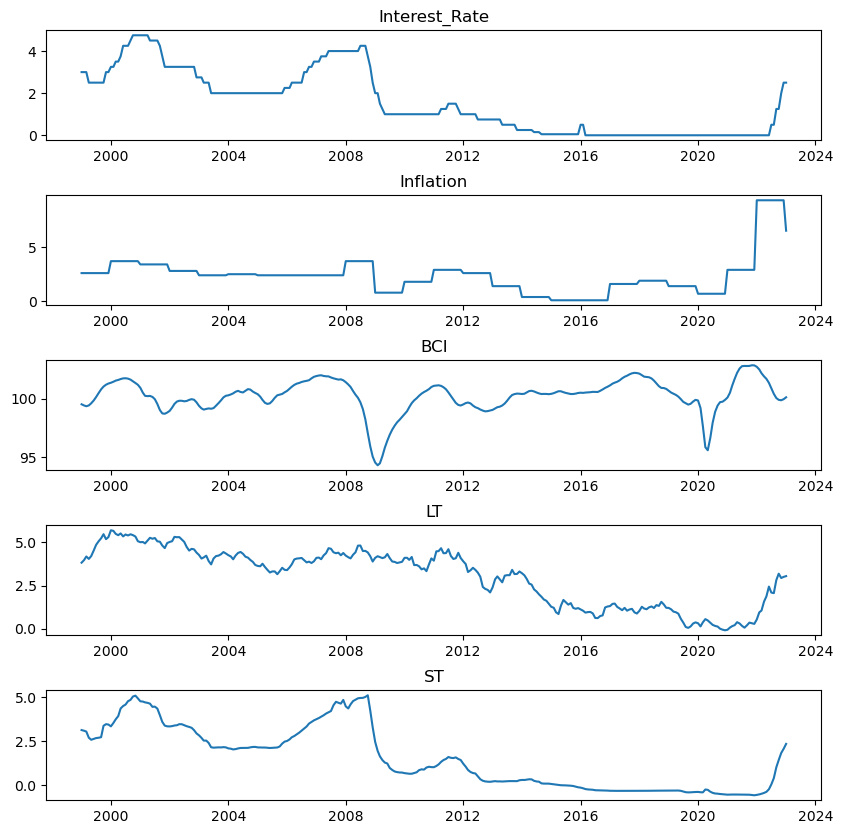

In [127]:
fig, axes = plt.subplots(5)
plt.subplots_adjust(hspace = 0.5)
fig.set_figheight(10)
fig.set_figwidth(10)
for ax in range(5):
    axes[ax].set_title(var_cols[ax])
    axes[ax].plot(data.index, data.loc[:, var_cols[ax]])
plt.show()

Train-Validation-Test Split:

In [128]:
split = round(len(data)*0.65) #train - validation split
split2 = round(len(data)*0.80) #validation - test split
train = data.iloc[:split, ].copy()
val = data.iloc[split:split2, ].copy()
test = data.iloc[split2:, ].copy()

full_train = data.iloc[:split2, ].copy()

In [129]:
def linear_var(df, expr):
    y_train, X_train = dmatrices(expr, df, return_type = 'dataframe')
    lm = linear_model.OLS(y_train, X_train).fit()
    return lm

In [130]:
expr_lm1 = 'Interest_Rate ~ Inflation + BCI + LT + ST'

In [131]:
lm1 = linear_var(train, expr_lm1)

In [132]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest_Rate   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1528.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          2.33e-139
Time:                        12:40:29   Log-Likelihood:                 15.743
No. Observations:                 188   AIC:                            -21.49
Df Residuals:                     183   BIC:                            -5.304
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3509      1.229     -0.286      0.776      -2.776       2.074
Inflation      0.0533      0.029      1.817      0.071      -0.005       0.111
BCI            0.0037      0.012      0.305      0.761      -0.021       0.028
LT             0.0426      0.032      1.324      0.187      -0.021       0.106
ST             0.8140      0.019     42.895      0.000       0.777       0.851
==============================================================================
Omnibus:                        5.351   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                7.021
Skew:                          -0.142   Prob(JB):                       0.0299
Kurtosis:                       3.903   Cond. No.                     7.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Aiming to correct multicollinearity and leave only significant variables, I remove predictors BCI and LT from the regression.

In [133]:
expr_lm2 = 'Interest_Rate ~ Inflation + ST'

In [134]:
lm2 = linear_var(train, expr_lm2)

In [135]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Interest_Rate   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3058.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          1.85e-142
Time:                        12:40:29   Log-Likelihood:                 14.833
No. Observations:                 188   AIC:                            -23.67
Df Residuals:                     185   BIC:                            -13.96
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1425      0.051      2.804      0.006       0.042       0.243
Inflation      0.0629      0.028      2.227      0.027       0.007       0.119
ST             0.8275      0.016     51.593      0.000       0.796       0.859
==============================================================================
Omnibus:                        7.798   Durbin-Watson:                   0.367
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               11.278
Skew:                          -0.227   Prob(JB):                      0.00356
Kurtosis:                       4.110   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model will be used. As expected, the Durbin-Watson, which measures the degree of lag-1 autocorrelation in the residuals of the regression, has a value close to 0, indicating strong positive lag-1 autocorrelation.

The next step is fitting an ARIMA (or SARIMA, if seasonality is detected), to the residuals of the OLS regression.

# SARIMA Specification

Next, the regression residual errors are modeled using SARIMA(p, d, q)(P, D, Q)m.

We plot the autocorrelation and partial autocorrelation plots of the regression residuals and choose the (S)ARIMA parameters by inspection, as we did before:

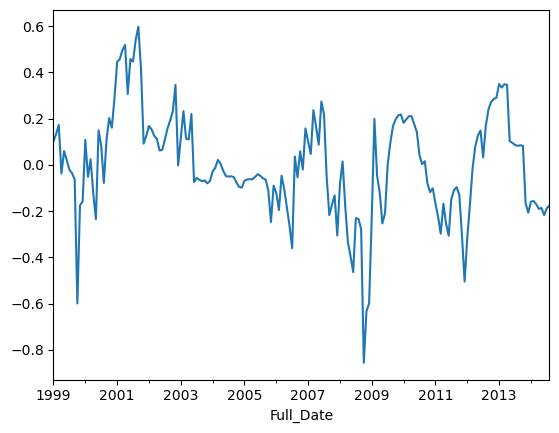

In [136]:
lm2.resid.plot()
plt.show()

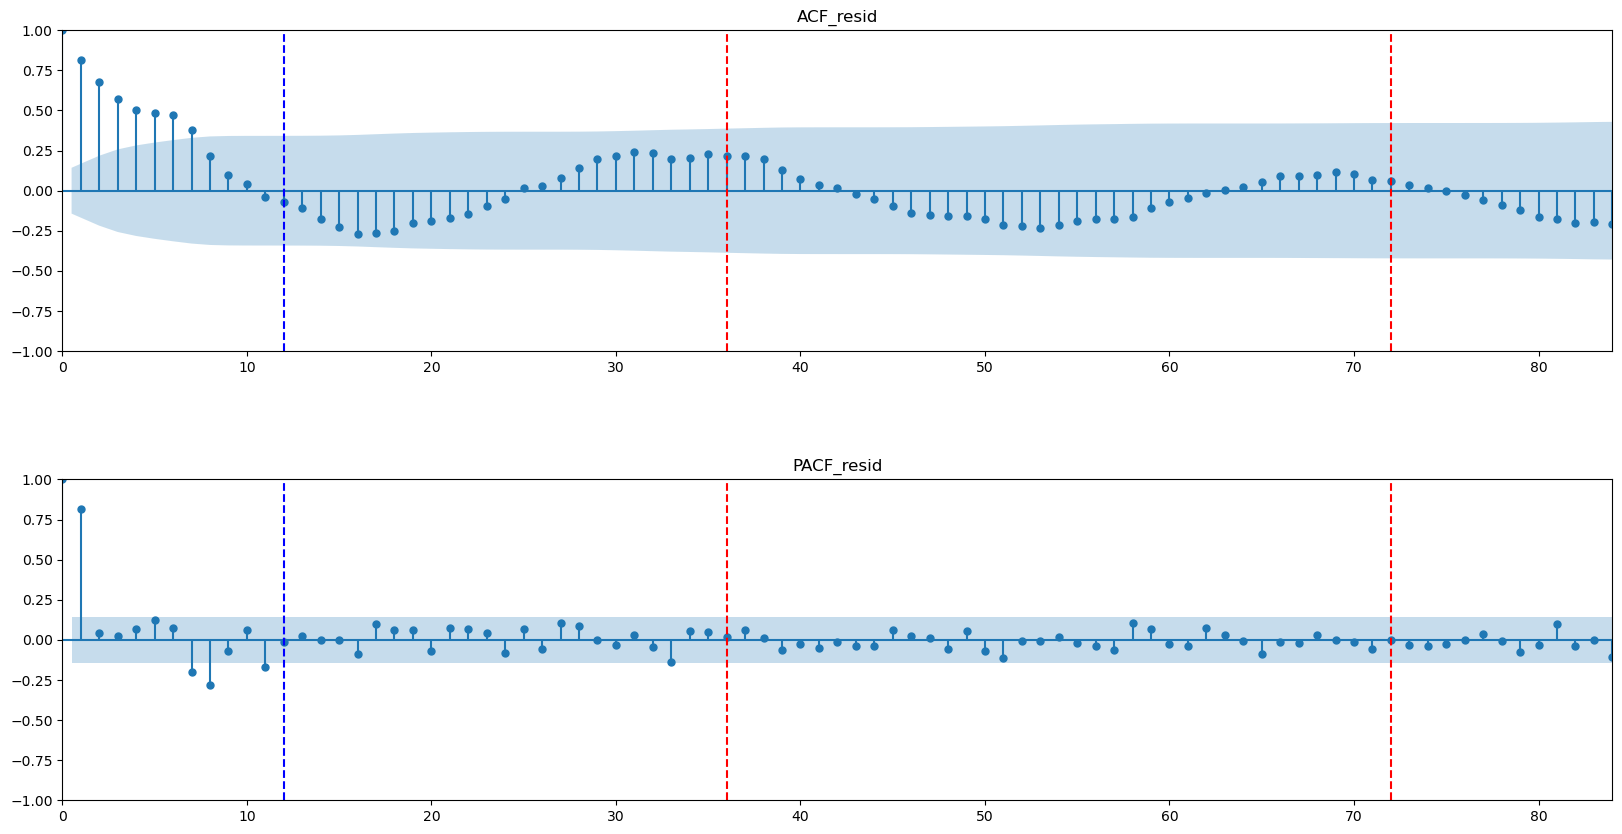

In [88]:
lag = 12*7
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(lm2.resid, ax = axes[0], lags = lag,
                title = 'ACF_resid')
axes[0].axvline(x = 12, linestyle = '--', color = 'b')
axes[0].axvline(x = 12*3, linestyle = '--', color = 'r')
axes[0].axvline(x = 12*6, linestyle = '--', color = 'r')

plot_pacf(lm2.resid, ax = axes[1], lags = lag,
                title = 'PACF_resid')
axes[1].axvline(x = 12, linestyle = '--', color = 'b')
axes[1].axvline(x = 12*3, linestyle = '--', color = 'r')
axes[1].axvline(x = 12*6, linestyle = '--', color = 'r')

By the plots above, we see that the residuals show no strong trend, but the series does not seem stationary, as the autocorrelations show some persistence, and there is a clear wavelike pattern in the ACF which may indicate some seasonality component.

In [136]:
adfuller(lm2.resid, regression = 'c')

(-3.866504703831952,
 0.002295659917463183,
 7,
 180,
 {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531},
 -248.36624482884366)

The ADF test rejects the hypothesis of a unit root. Hence, we set d = 0. Our model has no first-order differencing. <br>
However, again we could try differencing the series anyway and see what happens:

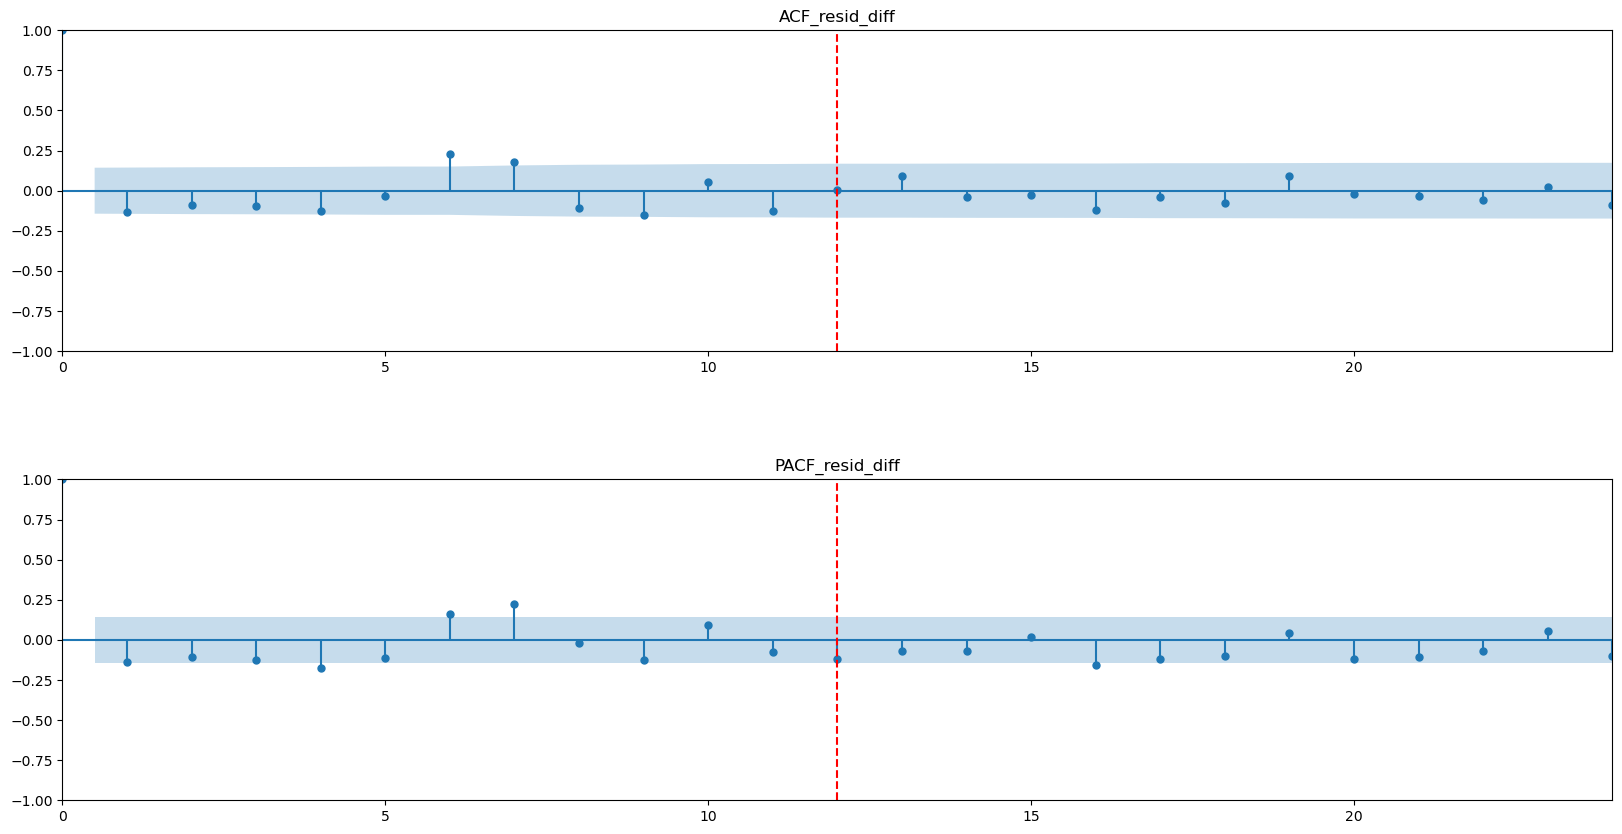

In [93]:
resid_diff = lm2.resid.diff().dropna()

lag = 12*2
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(resid_diff, ax = axes[0], lags = lag,
                title = 'ACF_resid_diff')
axes[0].axvline(x = 12, linestyle = '--', color = 'r')

plot_pacf(resid_diff, ax = axes[1], lags = lag,
                title = 'PACF_resid_diff')
axes[1].axvline(x = 12, linestyle = '--', color = 'r')

We see a negative lag-1 autocorrelation, indicating the series is probably over-differenced and so we should stick to d = 0.

To make the series stationary, we could try taking a seasonal difference. We look again at the ACF plot:

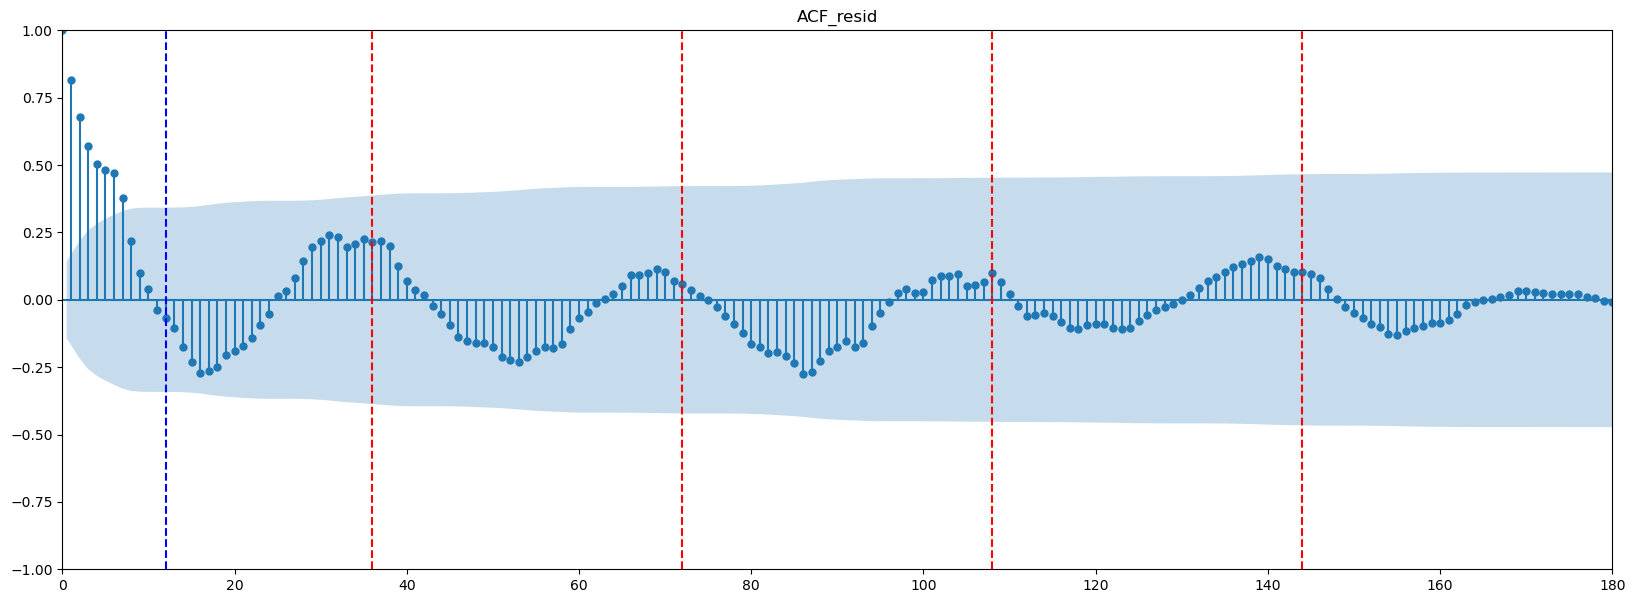

In [188]:
s = 36

lag = 12*15
fig, axes = plt.subplots(1)
fig.set_figheight(7)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(lm2.resid, ax = axes, lags = lag,
                title = 'ACF_resid')
axes.axvline(x = 12, linestyle = '--', color = 'b')
axes.axvline(x = s, linestyle = '--', color = 'r')
axes.axvline(x = s*2, linestyle = '--', color = 'r')
axes.axvline(x = s*3, linestyle = '--', color = 'r')
axes.axvline(x = s*4, linestyle = '--', color = 'r')

We see that the seasonal peaks seem to be more or less at lags of multiple of 36 months, i.e. 3 years. So we could try differencing at lag-36. Under this choice, we set m = 36 and D = 1.

In [137]:
resid_diff = lm2.resid.diff(periods = 36).dropna()

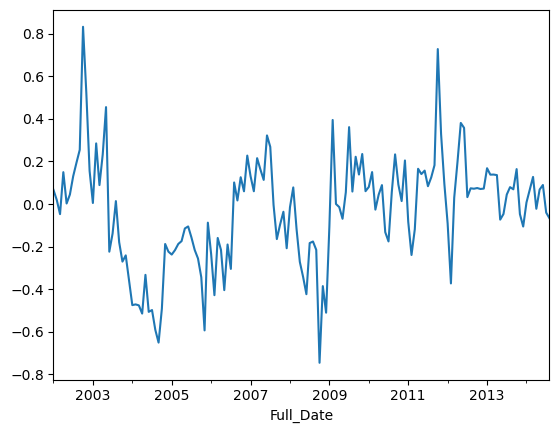

In [138]:
resid_diff.plot()
plt.show()

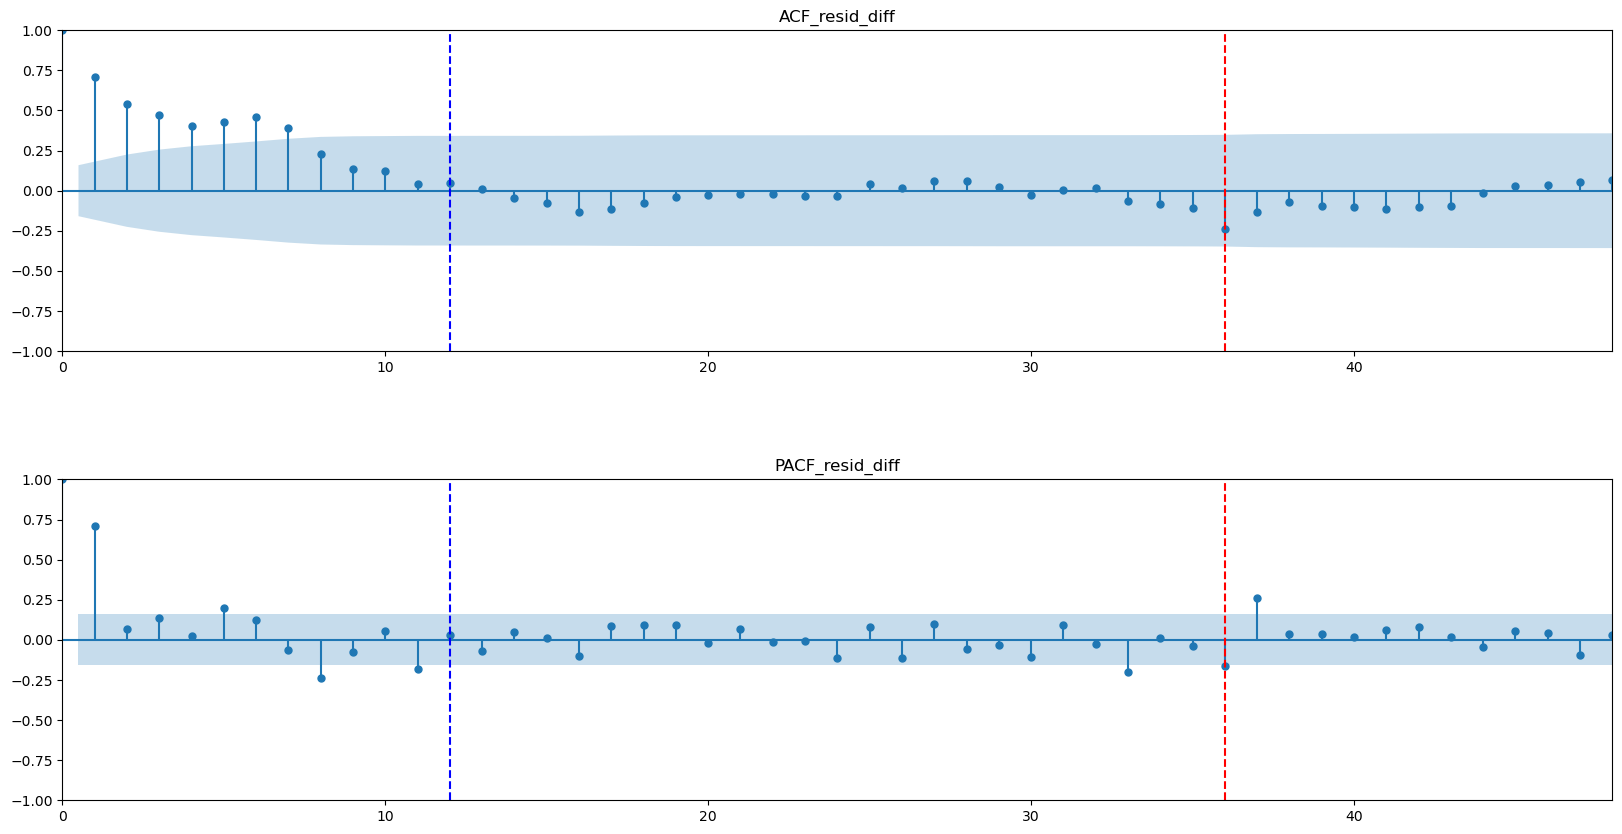

In [198]:
lag = 12*4
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
plt.subplots_adjust(hspace=0.4)
plt.setp(axes, xlim = (0, lag))

plot_acf(resid_diff, ax = axes[0], lags = lag,
                title = 'ACF_resid_diff')
axes[0].axvline(x = 12, linestyle = '--', color = 'b')
axes[0].axvline(x = 12*3, linestyle = '--', color = 'r')

plot_pacf(resid_diff, ax = axes[1], lags = lag,
                title = 'PACF_resid_diff')
axes[1].axvline(x = 12, linestyle = '--', color = 'b')
axes[1].axvline(x = 12*3, linestyle = '--', color = 'r')

The new residuals indeed show no seasonality. Looking at the PACF of the differenced series, we observe the partial autocorrelation truncated at a strong lag-1, while the autocorrelation starts decaying only after lag-6. Then we choose p = 1 and, to make the model more parsimonious that what the plots would otherwise suggest, q = 1. Finally, we set P = 0 and, for the little spike in the ACF at the seasonal lag, Q = 1.

Our SARIMA specification is: SARIMA(1, 0, 1)(0, 1, 1)36

## Sarimax Implementation

In [85]:
y_train, X_train = dmatrices(expr_lm2, train, return_type = 'dataframe')
y_val, X_val = dmatrices(expr_lm2, val, return_type = 'dataframe')
y_test, X_test = dmatrices(expr_lm2, test, return_type = 'dataframe')

In [56]:
sarimax_main = ARIMA(endog = y_train, exog = X_train, order=(1, 0, 1), seasonal_order = (0, 1, 1, 36))
sarimax_main_res = sarimax_main.fit()

In [201]:
sarimax_main_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                    Interest_Rate   No. Observations:                  188
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 36)   Log Likelihood                  75.744
Date:                          Sun, 04 Feb 2024   AIC                           -137.489
Time:                                  21:14:09   BIC                           -116.322
Sample:                                       0   HQIC                          -128.890
                                          - 188                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.051e-06   2.19e-05     -0.094      0.925   -4.49e-05    4.08e-05
Inflation      0.0438      0.035      1.238      0.216      -0.026       0.113
ST             0.7506      0.036     21.060      0.000       0.681       0.820
ar.L1          0.9307      0.038     24.293      0.000       0.856       1.006
ma.L1         -0.2439      0.091     -2.672      0.008      -0.423      -0.065
ma.S.L36      -0.9916      7.363     -0.135      0.893     -15.422      13.439
sigma2         0.0146      0.107      0.136      0.892      -0.195       0.225
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                33.56
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.52e+21. Standard errors may be unstable.
"""

We see that the Ljung-Box test gives a p-value of 0.83, hence there is no statistically significant autocorrelation in the residuals of the SARIMAX, as desired.

Despite this being our model specified by inspection, we run a grid search to compare multiple different specifications 1. on a validation set and 2. through Akaike’s Information Criterion (AIC). <br>
**Grid search:**

In [205]:
steps = len(val)
best_model_val = {'specification': "", 'mse': inf}
best_model_aic = {'specification': "", 'aic': inf}

m = 36
for p in [0, 1, 2]:
    for d in [0, 1]:
        for q in [0, 1, 2]:
            for P in [0, 1]:
                for D in [0, 1]:
                    for Q in [0, 1]:
                        sarimax = ARIMA(endog = y_train, exog = X_train,
                                        order= (p, d, q), seasonal_order = (P, D, Q, m), trend = 'n')
                        sarimax_res = sarimax.fit()

                        preds = sarimax_res.get_forecast(steps = steps, exog = X_val)
                        preds_sf = preds.summary_frame()

                        specification = f'SARIMAX({p}, {d}, {q})({P}, {D}, {Q})({m})'
                        mse = ((preds_sf['mean'] - val['Interest_Rate'])**2).mean()

                        if mse < best_model_val['mse']:
                            best_model_val['specification'] = specification
                            best_model_val['mse'] = mse
                            
                        if sarimax_res.aic < best_model_aic['aic']:
                            best_model_aic['specification'] = specification
                            best_model_aic['aic'] = sarimax_res.aic

                        print(specification, 'MSE:', mse, 'AIC:', sarimax_res.aic)

SARIMAX(0, 0, 0)(0, 0, 0)(36) MSE: 0.018878162197339593 AIC: -21.665072813048496
SARIMAX(0, 0, 0)(0, 0, 1)(36) MSE: 0.01754941203858382 AIC: -33.88786020985965
SARIMAX(0, 0, 0)(0, 1, 0)(36) MSE: 0.04936457836439098 AIC: 25.347191747217
SARIMAX(0, 0, 0)(0, 1, 1)(36) MSE: 0.03077647323825927 AIC: 1.9056288012514706
SARIMAX(0, 0, 0)(1, 0, 0)(36) MSE: 0.015204011628895602 AIC: -33.49647832795762
SARIMAX(0, 0, 0)(1, 0, 1)(36) MSE: 0.017104718414711242 AIC: -33.73452277103212
SARIMAX(0, 0, 0)(1, 1, 0)(36) MSE: 0.04515127830953963 AIC: 13.9189955407282
SARIMAX(0, 0, 0)(1, 1, 1)(36) MSE: 0.025263748154623 AIC: 0.17570214929643768
SARIMAX(0, 0, 1)(0, 0, 0)(36) MSE: 0.018200237455143202 AIC: -134.9858468199671
SARIMAX(0, 0, 1)(0, 0, 1)(36) MSE: 0.01566335687549456 AIC: -138.3633657586907
SARIMAX(0, 0, 1)(0, 1, 0)(36) MSE: 0.04834207836973727 AIC: -45.61599392418492
SARIMAX(0, 0, 1)(0, 1, 1)(36) MSE: 0.02423729657869853 AIC: -82.30694872475608
SARIMAX(0, 0, 1)(1, 0, 0)(36) MSE: 0.0148306134499065

SARIMAX(2, 0, 0)(1, 1, 1)(36) MSE: 0.022526409117142272 AIC: -137.01613671493968
SARIMAX(2, 0, 1)(0, 0, 0)(36) MSE: 0.035174707821226586 AIC: -230.1193308600098
SARIMAX(2, 0, 1)(0, 0, 1)(36) MSE: 0.03700896053712568 AIC: -228.31011995117785
SARIMAX(2, 0, 1)(0, 1, 0)(36) MSE: 0.05659417314639482 AIC: -85.56698258311837
SARIMAX(2, 0, 1)(0, 1, 1)(36) MSE: 0.020171336499116076 AIC: -133.3819836010106
SARIMAX(2, 0, 1)(1, 0, 0)(36) MSE: 0.048296005037608246 AIC: -228.23445949258434
SARIMAX(2, 0, 1)(1, 0, 1)(36) MSE: 0.020936144362875907 AIC: -228.69278806290168
SARIMAX(2, 0, 1)(1, 1, 0)(36) MSE: 0.03259091744920783 AIC: -120.52134738636246
SARIMAX(2, 0, 1)(1, 1, 1)(36) MSE: 0.021167175565023028 AIC: -141.0920516237433
SARIMAX(2, 0, 2)(0, 0, 0)(36) MSE: 0.05329551289229415 AIC: -226.9174388216358
SARIMAX(2, 0, 2)(0, 0, 1)(36) MSE: 0.06019064811075367 AIC: -225.13924433930248
SARIMAX(2, 0, 2)(0, 1, 0)(36) MSE: 0.055772767122233384 AIC: -85.20675679981031
SARIMAX(2, 0, 2)(0, 1, 1)(36) MSE: 0.01

In [208]:
best_model_val

{'specification': 'SARIMAX(2, 0, 2)(1, 1, 1)(36)', 'mse': 0.014217083529853255}

In [209]:
best_model_aic

{'specification': 'SARIMAX(2, 1, 2)(0, 0, 0)(36)', 'aic': -233.82245887282068}

Results: <br>
Simple OLS, i.e. SARIMAX(0, 0, 0)(0, 0, 0)(36), obtained a 0.018878162197339593 MSE on the validation set, better than most models. <br>
The best model for validation set MSE is SARIMAX(2, 0, 2)(1, 1, 1)(36), with a score of 0.014217083529853255. <br>
The best model for AIC is SARIMAX(2, 1, 2)(0, 0, 0)(36) with a score of -233.82245887282068. <br>
Our manually specified model SARIMAX(1, 0, 1)(0, 1, 1)(36) has a MSE of 0.02891230433380169 and an AIC of -137.48897420453778.

Finally, we evaluate and compare the performance on the test set of: 1. simple OLS, 2. the manually specified SARIMAX(1, 0, 1)(0, 1, 1)(36), 3. SARIMAX(2, 0, 2)(1, 1, 1)(36) and 4. SARIMAX(2, 1, 2)(0, 0, 0)(36).

## Prediction

I fit the four models on the train + validation set.

In [139]:
lm2 = linear_var(full_train, expr_lm2)

ols_pred = lm2.predict(X_test)

In [140]:
steps = len(test)
y_full_train, X_full_train = dmatrices(expr_lm2, full_train, return_type = 'dataframe')

In [141]:
sarimax_main = ARIMA(endog = y_full_train, exog = X_full_train, 
                     order=(1, 0, 1), seasonal_order = (0, 1, 1, 36))
sarimax_main_res = sarimax_main.fit()

preds_main = sarimax_main_res.get_forecast(steps = steps, exog = X_test)
preds_main_sf = preds_main.summary_frame()

main_pred = preds_main_sf['mean']

In [142]:
preds_main_sf.head()

Interest_Rate,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-04-01,-0.020828,0.127949,-0.271603,0.229948
2018-05-01,-0.038653,0.156460,-0.345309,0.268002
2018-06-01,-0.019948,0.173709,-0.360411,0.320515
2018-07-01,-0.025000,0.184864,-0.387326,0.337326
2018-08-01,0.056832,0.192311,-0.320091,0.433756


In [143]:
sarimax_b1 = ARIMA(endog = y_full_train, exog = X_full_train, 
                     order=(2, 0, 2), seasonal_order = (1, 1, 1, 36))
sarimax_b1_res = sarimax_b1.fit()

preds_b1 = sarimax_b1_res.get_forecast(steps = steps, exog = X_test)
preds_b1_sf = preds_b1.summary_frame()

b1_pred = preds_b1_sf['mean']

In [144]:
sarimax_b2 = ARIMA(endog = y_full_train, exog = X_full_train, 
                     order=(2, 1, 2), seasonal_order = (0, 0, 0, 36))
sarimax_b2_res = sarimax_b2.fit()

preds_b2 = sarimax_b2_res.get_forecast(steps = steps, exog = X_test)
preds_b2_sf = preds_b2.summary_frame()

b2_pred = preds_b2_sf['mean']

Plotting the three predictions:

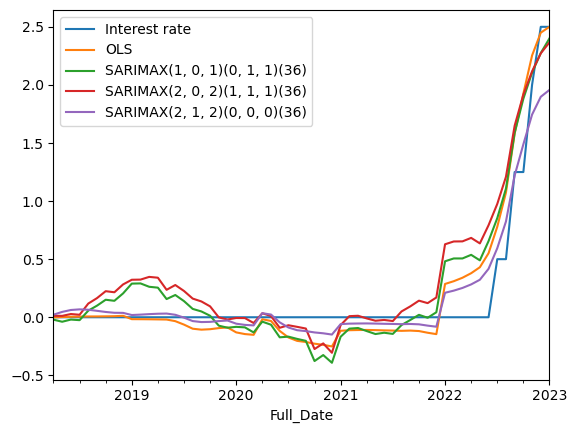

In [145]:
test['Interest_Rate'].plot(label = 'Interest rate')
ols_pred.plot(label = 'OLS')
main_pred.plot(label = 'SARIMAX(1, 0, 1)(0, 1, 1)(36)')
b1_pred.plot(label = 'SARIMAX(2, 0, 2)(1, 1, 1)(36)')
b2_pred.plot(label = 'SARIMAX(2, 1, 2)(0, 0, 0)(36)')
plt.legend()
plt.show()

In [149]:
#OLS regression MSE
((ols_pred - test['Interest_Rate'])**2).mean()

0.04404358345794255

In [150]:
#SARIMAX(1, 0 ,1)(0, 1, 1)(36) MSE
((main_pred - test['Interest_Rate'])**2).mean()

0.0687351575121847

In [151]:
#SARIMAX(2, 0, 2)(1, 1, 1)(36) MSE
((b1_pred - test['Interest_Rate'])**2).mean()

0.09308598216203026

In [152]:
#SARIMAX(2, 1, 2)(0, 0, 0)(36) MSE
((b2_pred - test['Interest_Rate'])**2).mean()

0.02758336016632124

On the test set, OLS plus residuals modeled with a SARIMA(2, 1, 2)(0, 0, 0)(36) gives the best results.

Finally, we plot the predictions of the best performing model and the manually specified one with prediction intervals at level 0.7 and 0.95.

Plot of predictions for the OLS + SARIMA(1, 0, 1)(0, 1, 1)(36):

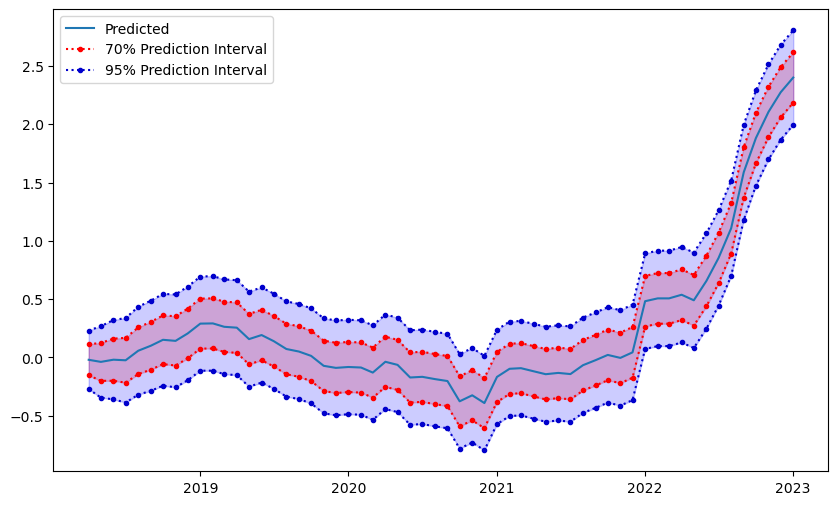

In [146]:
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(preds_main_sf.loc[:, 'mean'], label = 'Predicted')

axes.plot(preds_main_sf['mean'] - 1.04*preds_main_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':')
axes.plot(preds_main_sf['mean'] + 1.04*preds_main_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':', label='70% Prediction Interval')

axes.fill_between(preds_main_sf.index, preds_main_sf['mean'] - 1.04*preds_main_sf['mean_se'], 
                  preds_main_sf['mean'] + 1.04*preds_main_sf['mean_se'], 
                  color = 'r', alpha = 0.2)


axes.plot(preds_main_sf.loc[:, 'mean_ci_lower'], 
                 color='#0000cc', marker='.', linestyle=':')
axes.plot(preds_main_sf.loc[:, 'mean_ci_upper'], 
                 color='#0000cc', marker='.', linestyle=':', label='95% Prediction Interval')

axes.fill_between(preds_main_sf.index, preds_main_sf.loc[:, 'mean_ci_lower'], 
                  preds_main_sf.loc[:, 'mean_ci_upper'], 
                  color = 'b', alpha = 0.2)

axes.legend()
plt.show()

Plot of predictions for the best performing model: OLS + SARIMA(2, 1, 2)(0, 0, 0)(36):

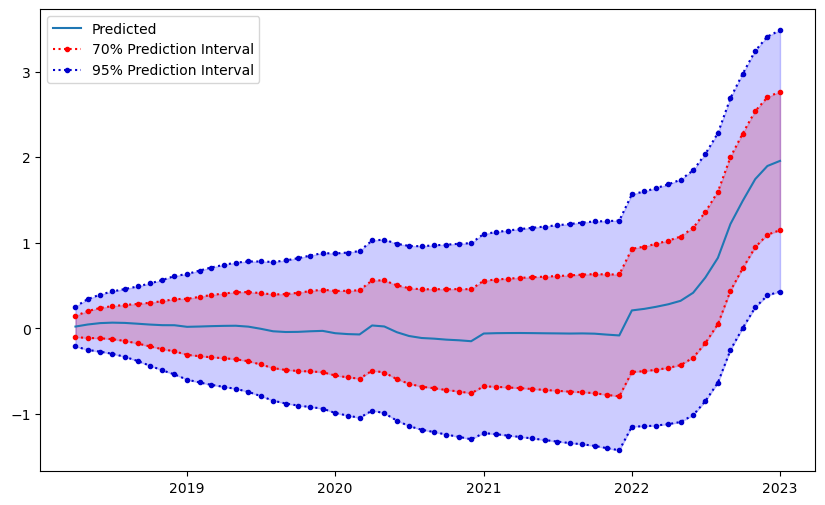

In [147]:
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(preds_b2_sf.loc[:, 'mean'], label = 'Predicted')

axes.plot(preds_b2_sf['mean'] - 1.04*preds_b2_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':')
axes.plot(preds_b2_sf['mean'] + 1.04*preds_b2_sf['mean_se'], 
                 color='#FF0000', marker='.', linestyle=':', label='70% Prediction Interval')

axes.fill_between(preds_b2_sf.index, preds_b2_sf['mean'] - 1.04*preds_b2_sf['mean_se'], 
                  preds_b2_sf['mean'] + 1.04*preds_b2_sf['mean_se'], 
                  color = 'r', alpha = 0.2)


axes.plot(preds_b2_sf.loc[:, 'mean_ci_lower'], 
                 color='#0000cc', marker='.', linestyle=':')
axes.plot(preds_b2_sf.loc[:, 'mean_ci_upper'], 
                 color='#0000cc', marker='.', linestyle=':', label='95% Prediction Interval')

axes.fill_between(preds_b2_sf.index, preds_b2_sf.loc[:, 'mean_ci_lower'], 
                  preds_b2_sf.loc[:, 'mean_ci_upper'], 
                  color = 'b', alpha = 0.2)

axes.legend()
plt.show()